## Generate pairplots unselected and selected libraries 

Figure out how much and how consistently they've been selected

Comare outgrowths to actual selections

Remove all NaN values, there's enough data to still see what's going on


In [1]:
# import packages, define correlation function for pairplots 
import numpy as np
import itertools
import math
import pandas as pd
import time
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
import matplotlib
import matplotlib.pyplot as plt
from ast import literal_eval
import csv
import venn
from numpy import cov
from scipy.stats import spearmanr, pearsonr
from scipy import stats
from numpy import cov
import seaborn as sns
sns.set(style="white")

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    

In [2]:
# This information has to be input manually: File names, barcode flank sequences 

SSFlank = 'GGTGGTGACC'

PBallBCs = 'PacBio_BCCounts.csv'
PBlookupTable = 'NP_11_21_1_BB_AB_lookupTable.csv'

listOfFiles = \
    [\
    'NP_11_24_01_BCCounts.csv',\
    'NP_11_24_10_1_BCCounts.csv',\
    'NP_11_24_11_1_BCCounts.csv',\
    'NP_11_24_18_BCCounts.csv',\
    'NP_11_24_19_BCCounts.csv',\
    'NP_11_27_21_BCCounts.csv',\
    'NP_11_27_22_BCCounts.csv',\
    'NP_11_27_23_BCCounts.csv'\
    ]

listOfFileNames = ['NP_11_24_01', 'NP_11_24_10_1', 'NP_11_24_11_1', 'NP_11_24_18', 'NP_11_24_19',
                   'NP_11_27_21', 'NP_11_27_22', 'NP_11_27_23']
listOfLibTypes = ['SS', 'SS', 'SS', 'SS', 'SS', 'SS', 'SS', 'SS']



In [3]:
# Make a dataframe with all of the data (each barcode and its frequency in each dataset)

PBlookupTableDF = pd.read_csv(PBlookupTable, index_col = 0).reset_index().rename(columns = 
                                                                                {'Barcode_sequence':'Barcode'})
PBBCDF = pd.read_csv(PBallBCs).reset_index(drop = True)[['Barcode', 'BCfrequency']].value_counts()
PBBCDF = pd.DataFrame(PBBCDF).reset_index()[['Barcode', 'BCfrequency']]
BCDF = PBBCDF.merge(PBlookupTableDF, how = 'inner',
                    on = 'Barcode').rename(columns = {'BCfrequency':'PacBio'}).drop(columns = 'index')

for dataFile in listOfFiles:
    dataDF = pd.read_csv(dataFile, index_col = 0).reset_index()
    dataDF.rename(columns={'index': 'Barcode'}, inplace = True)
    BCDF = BCDF.merge(dataDF, how = 'inner', on = 'Barcode')
    
# Add 0.01 to each value so that there are no errors
naValues = { i : 0.01 for i in listOfFileNames }
filledInBCDF = BCDF#.fillna(value=naValues)

# Remove barcodes that don't appear in PacBio since there won't be a denominator for enrichment
filledInBCDF = filledInBCDF[~pd.isnull(filledInBCDF['PacBio'])]

# Get enrichment value
# Normalize to total reads
for i, experiment in enumerate(listOfFileNames):
    totalReads = filledInBCDF[listOfFileNames[i]].sum()
    pacbioTotalReads = filledInBCDF['PacBio'].sum()
    filledInBCDF[listOfFileNames[i] + '_enrichment'] = \
        np.log((filledInBCDF[listOfFileNames[i]]/totalReads)/(filledInBCDF['PacBio']/pacbioTotalReads))

# Choose relevant data
columnsForPairplot = []
for i, experiment in enumerate(listOfFileNames):
    columnsForPairplot.append(experiment + '_enrichment')
pairplotData = filledInBCDF[columnsForPairplot]
    

Text(0.5, 1.01, 'LB outgrowths')

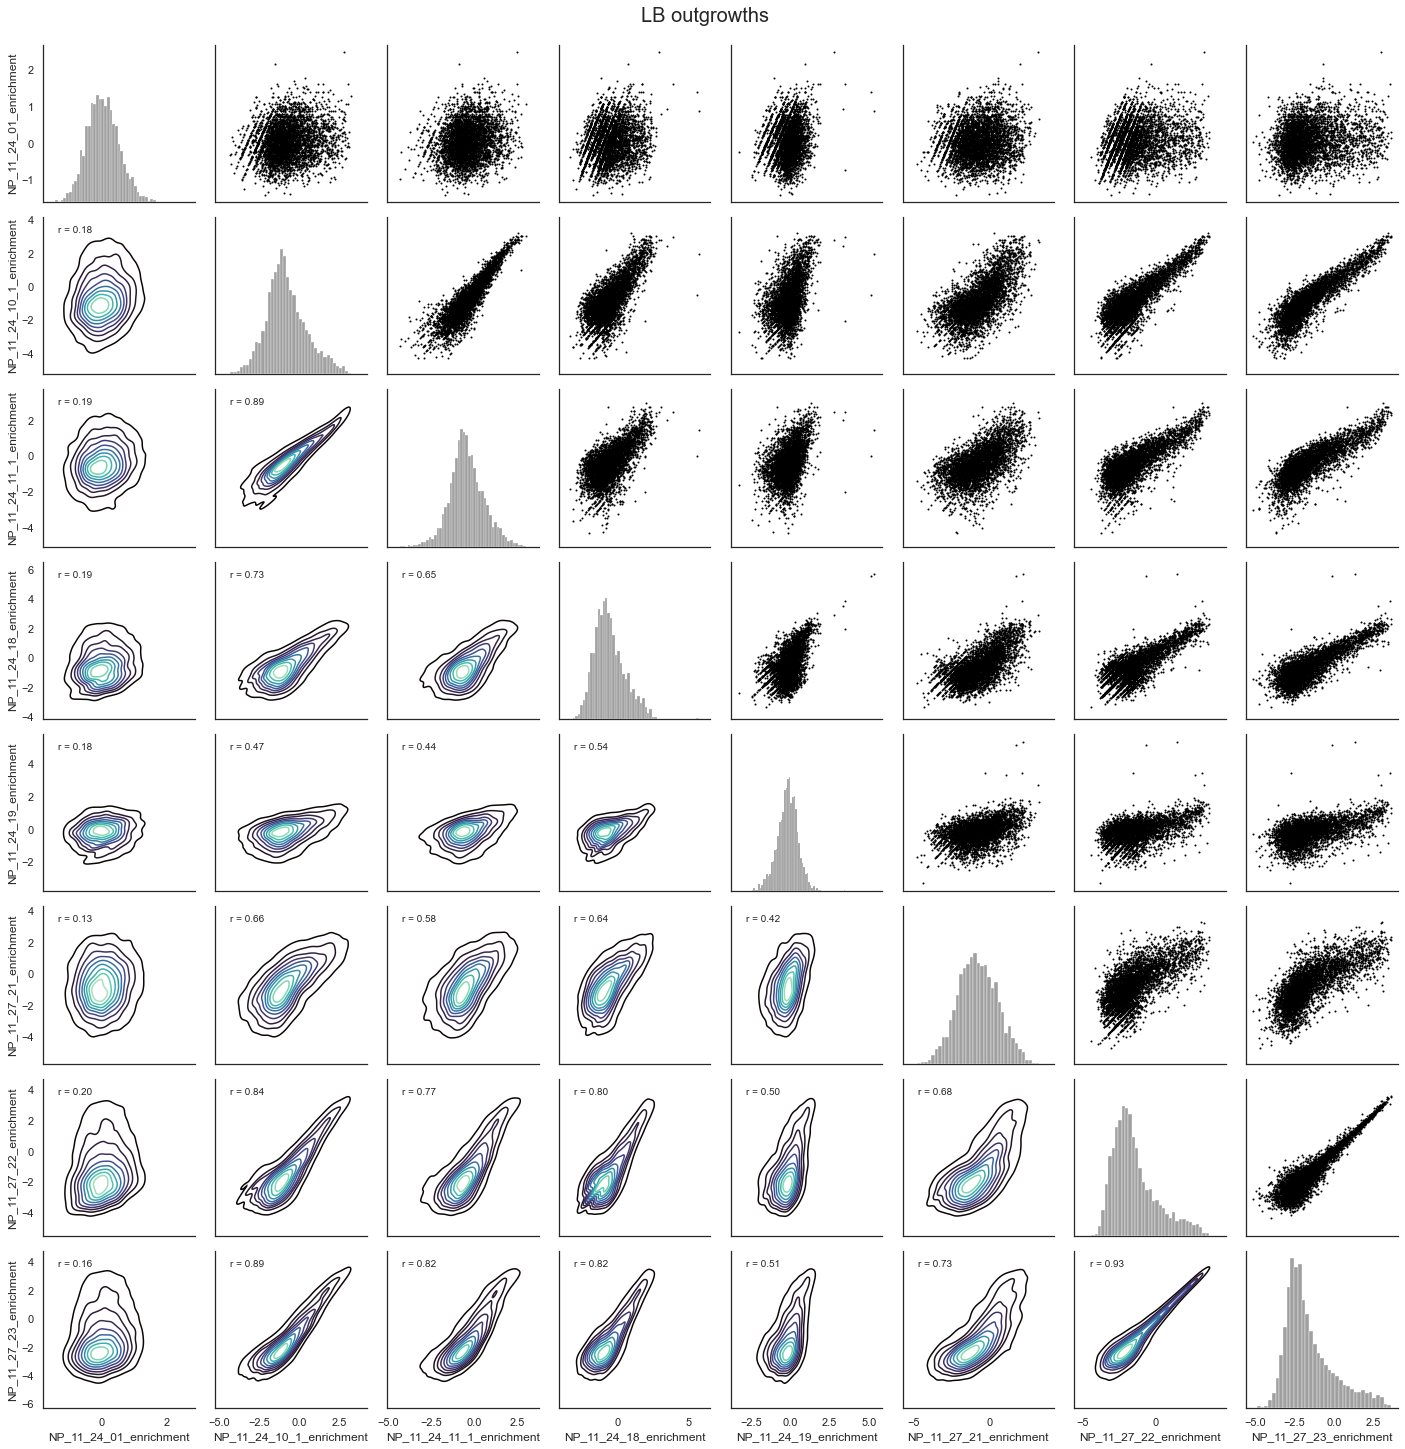

In [4]:
# Plot outgrowth replicates

g = sns.PairGrid(pairplotData, palette=["red"])
g.map_upper(plt.scatter, color = 'black', s=1)
g.map_diag(sns.histplot, color = 'grey', kde=False)
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap="mako")
g.fig.suptitle("LB outgrowths", y=1.01, size = 20)


/Users/noamprywes/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,7,8,9,10,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0.5, 1.01, 'Preselection vs. Postselection by Barcode')

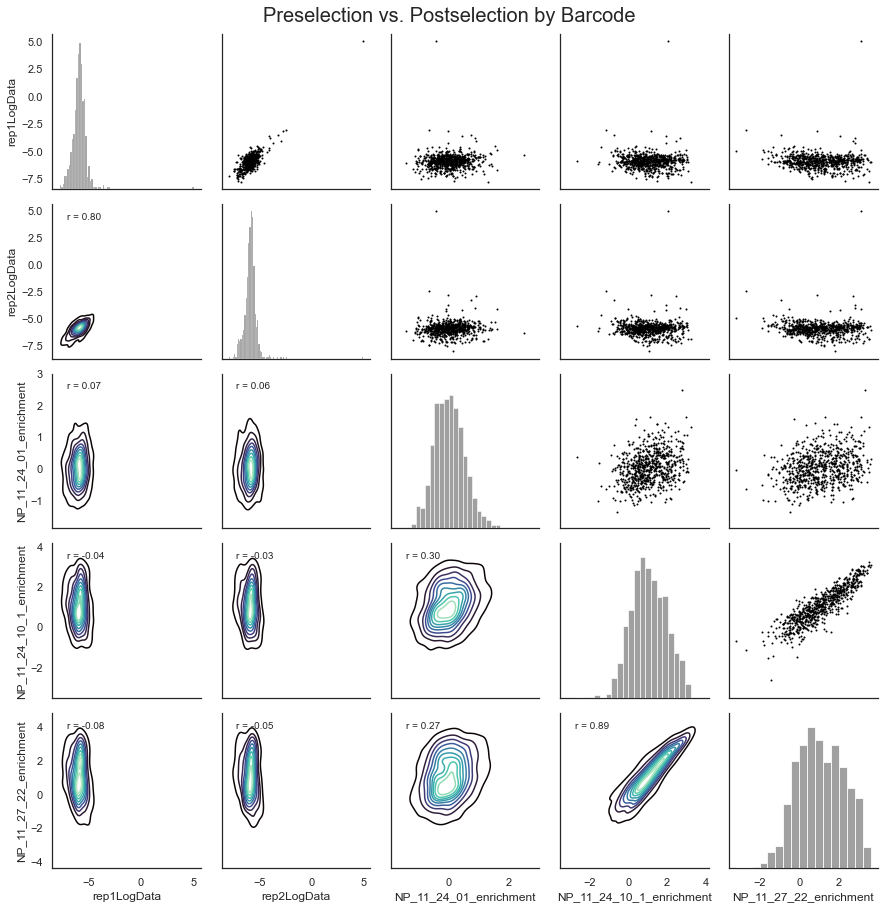

In [5]:
# Compare selection data to preselection data: Inner merge here reduced weird zero data


pd.set_option('display.max_columns', None)
selectionDF = pd.read_csv('NP_11_27_selection_first.csv')
selectionDF['rep1LogData'] = np.log(selectionDF['WT_norm_enrich_rep1'])
selectionDF['rep2LogData'] = np.log(selectionDF['WT_norm_enrich_rep2'])

preSelVsSelDF = filledInBCDF.merge(selectionDF, how = 'inner', on = 'Barcode')


preSelVsSelDF['avgPreSelEnrich'] = preSelVsSelDF[columnsForPairplot[1:]].mean(axis = 1)
preSelVsSelDF['STDPreSelEnrich'] = preSelVsSelDF[columnsForPairplot[1:]].std(axis = 1)


preSelVsSelData = preSelVsSelDF[['rep1LogData', 'rep2LogData', 
                               'NP_11_24_01_enrichment', 'NP_11_24_10_1_enrichment', 'NP_11_27_22_enrichment'
                               ]].dropna()


g = sns.PairGrid(preSelVsSelData, palette=["red"])
g.map_upper(plt.scatter, color = 'black', s=1)
g.map_diag(sns.histplot, color = 'grey', kde=False)
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap="mako")
g.fig.suptitle("Preselection vs. Postselection by Barcode", y=1.01, size = 20)

Text(0.5, 1.02, 'Preselection vs. Postselection by Mutant')

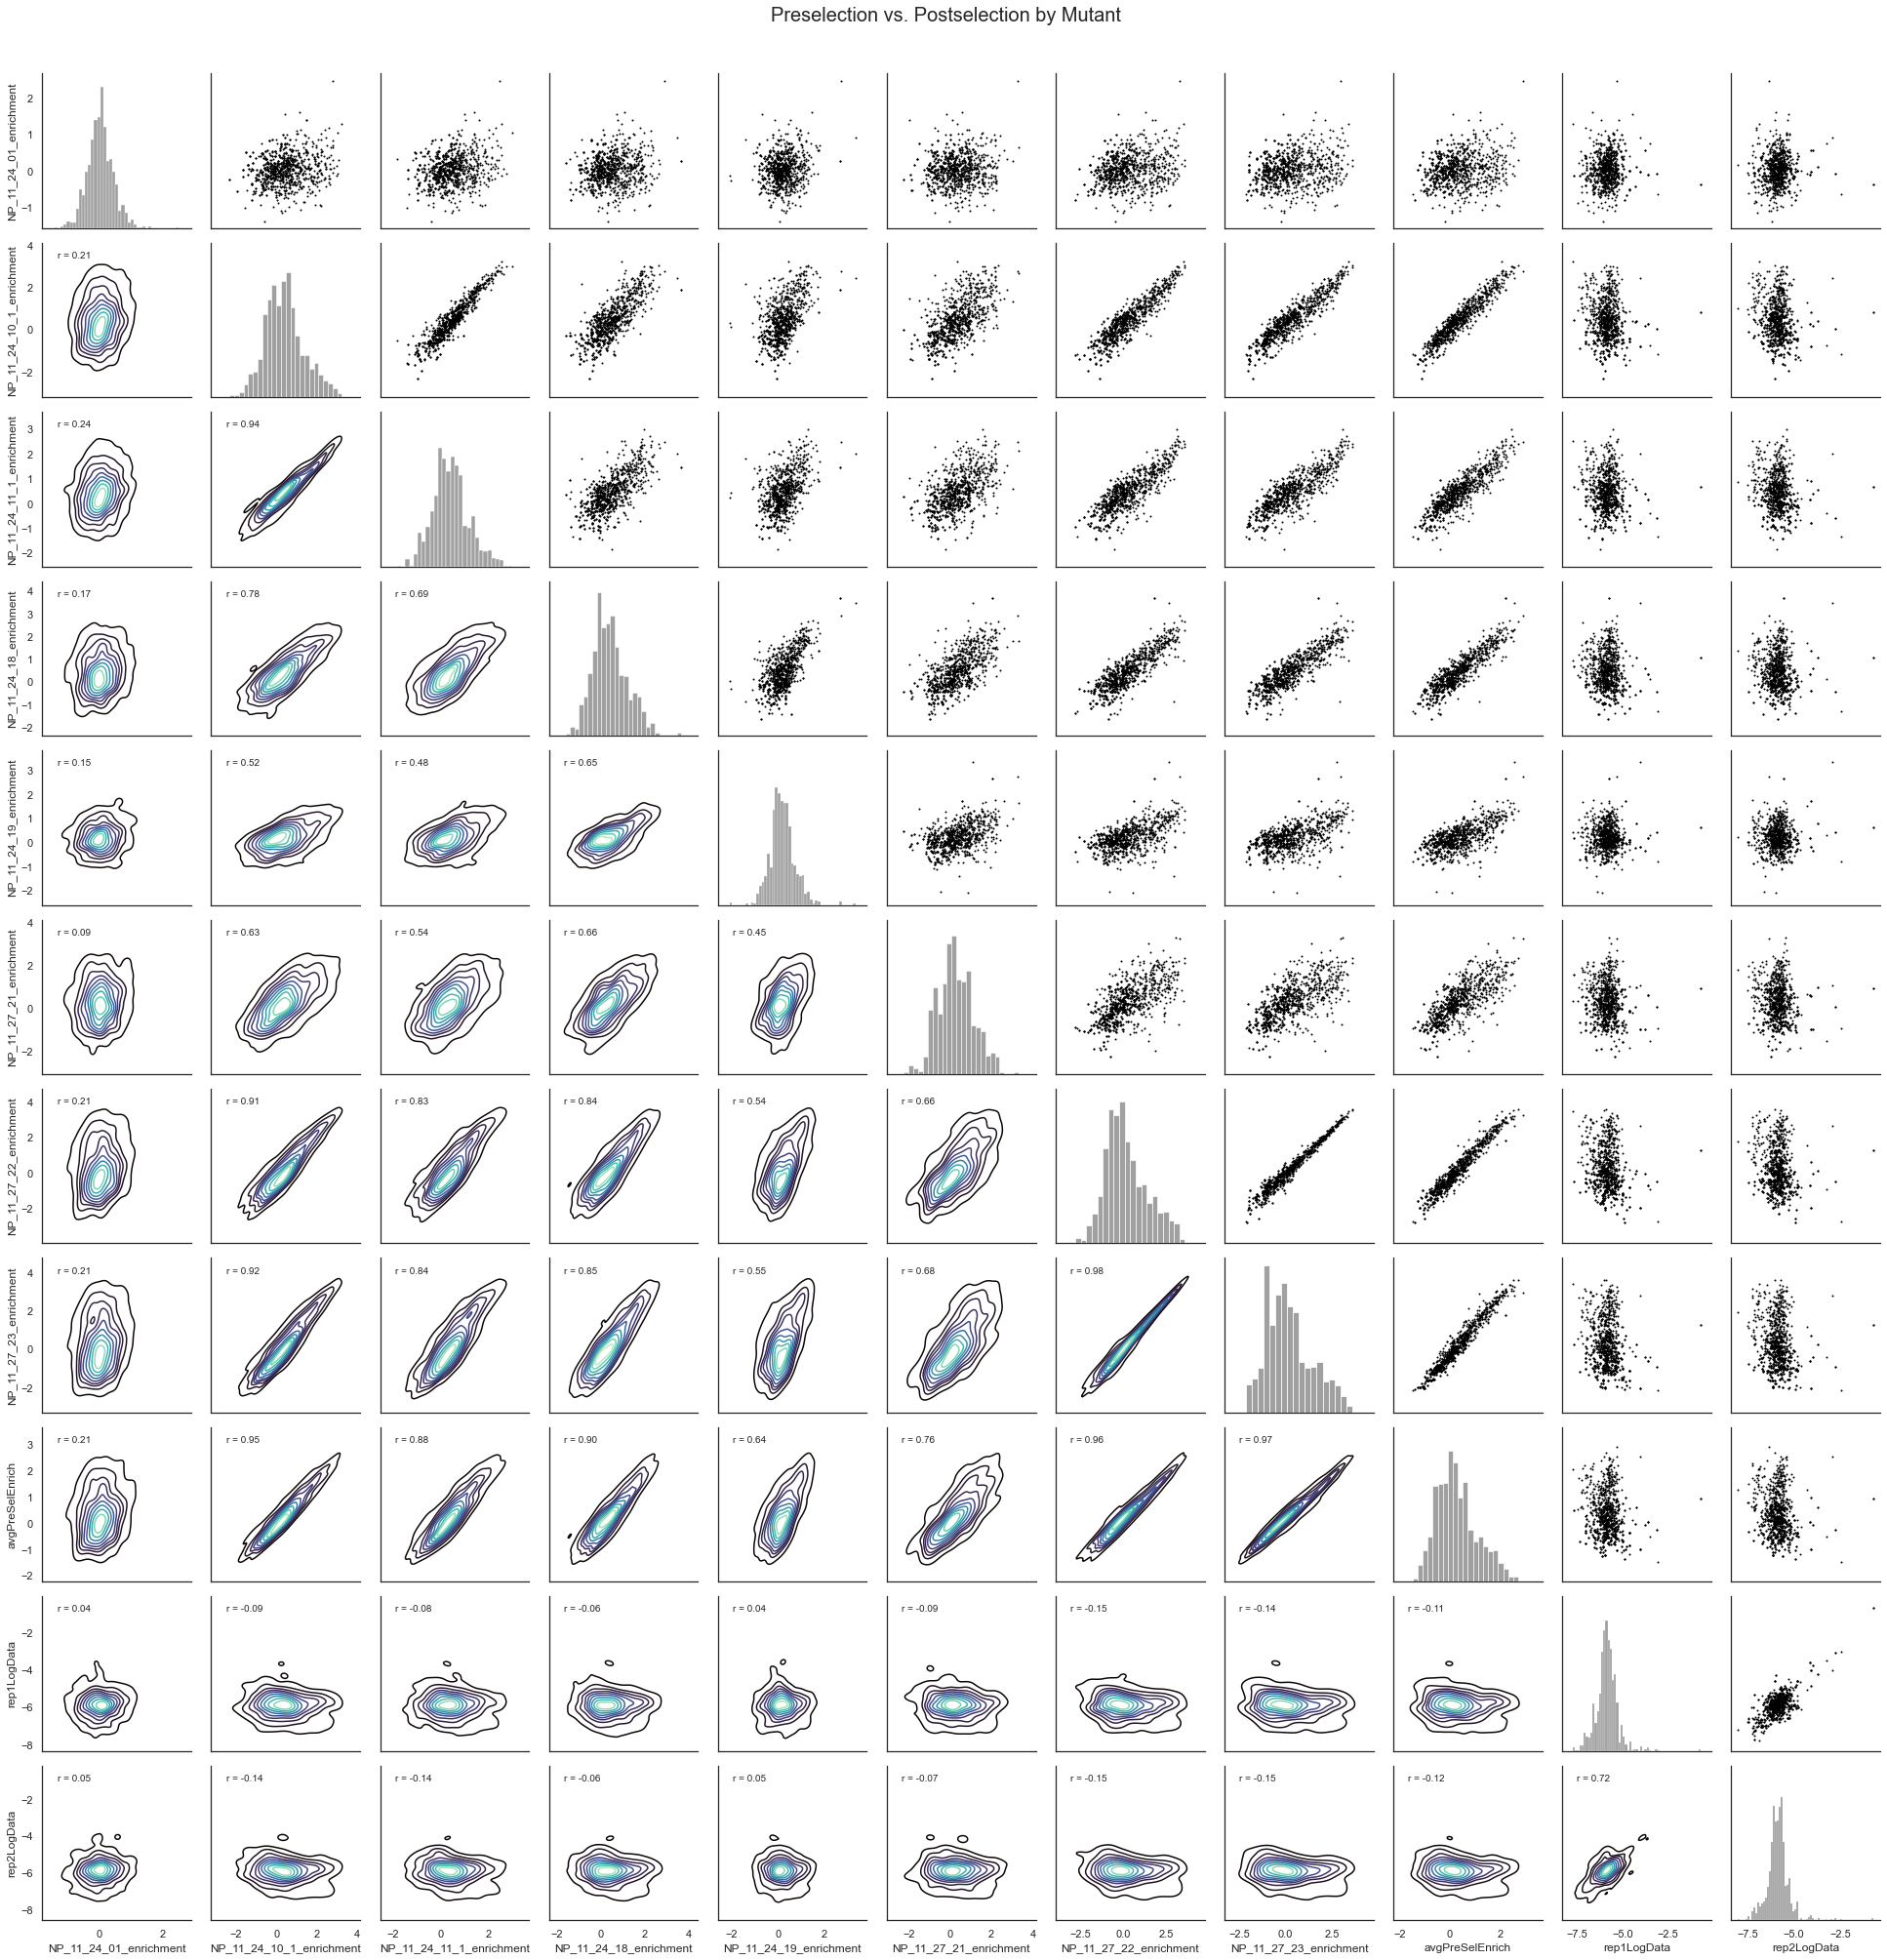

In [6]:
# Average across mutations and see if stuff is still correlated

mutAveragesCols = ['NP_11_24_01_enrichment', 'NP_11_24_10_1_enrichment', 'NP_11_24_11_1_enrichment', 
                   'NP_11_24_18_enrichment', 'NP_11_24_19_enrichment', 'NP_11_27_21_enrichment',
                   'NP_11_27_22_enrichment', 'NP_11_27_23_enrichment', 'avgPreSelEnrich',
                   'rep1LogData', 'rep2LogData']

mutAvgsDF = pd.DataFrame(preSelVsSelDF['correctedAAmut_x'])

for i, dataset in enumerate(mutAveragesCols):
    mutAvgs = preSelVsSelDF.groupby(['correctedAAmut_x'])[dataset].mean()
    mutAvgsDF = mutAvgsDF.merge(mutAvgs.to_frame(name = dataset), on = 'correctedAAmut_x')
    
mutAvgPairplotData = mutAvgsDF.iloc[:,np.arange(1,12,1)].dropna()

g = sns.PairGrid(mutAvgPairplotData, palette=["red"])
g.map_upper(plt.scatter, color = 'black', s=1)
g.map_diag(sns.histplot, color = 'grey', kde=False)
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap="mako")
g.fig.suptitle("Preselection vs. Postselection by Mutant", y=1.02, size = 20)

Text(0, 0.5, 'standard deviation')

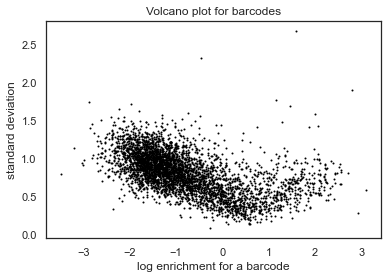

In [7]:
# Make a histogram of noise across replicates for a given barcode
columnsToAvg = []
for column in listOfFileNames:
    columnsToAvg.append(column + '_enrichment') 

filledInBCDF['BC_avg'] = filledInBCDF[columnsToAvg[1:]].mean(axis = 1)
filledInBCDF['BC_stdDev'] = filledInBCDF[columnsToAvg[1:]].std(axis = 1)

plt.scatter(filledInBCDF['BC_avg'], filledInBCDF['BC_stdDev'], s = 1, color = 'black')
plt.title('Volcano plot for barcodes')
plt.xlabel('log enrichment for a barcode')
plt.ylabel('standard deviation')

Text(0, 0.5, 'standard deviation')

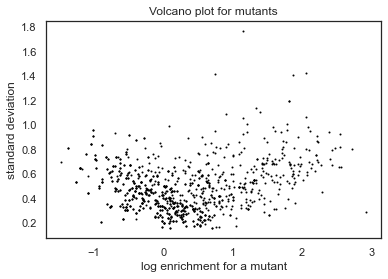

In [8]:
# Make a histogram of noise across barcodes for a given mutant

mutAvgPairplotData['mut_avg'] = mutAvgPairplotData[columnsToAvg[1:]].mean(axis = 1)
mutAvgPairplotData['mut_stdDev'] = mutAvgPairplotData[columnsToAvg[1:]].std(axis = 1)
plt.scatter(mutAvgPairplotData['mut_avg'], mutAvgPairplotData['mut_stdDev'], s = 1, color = 'black')
plt.title('Volcano plot for mutants')
plt.xlabel('log enrichment for a mutant')
plt.ylabel('standard deviation')


In [9]:
# 
PBlookupTableDF = pd.read_csv(PBlookupTable, index_col = 0).reset_index().rename(columns = 
                                                                                {'Barcode_sequence':'Barcode'})
PBBCDF = pd.read_csv(PBallBCs).reset_index(drop = True)[['Barcode', 'BCfrequency']].value_counts()
PBBCDF = pd.DataFrame(PBBCDF).reset_index()[['Barcode', 'BCfrequency']]
BCDFall = PBBCDF.merge(PBlookupTableDF, how = 'outer',
                    on = 'Barcode').rename(columns = {'BCfrequency':'PacBio'}).drop(columns = 'index')

for dataFile in listOfFiles:
    dataDF = pd.read_csv(dataFile, index_col = 0).reset_index()
    dataDF.rename(columns={'index': 'Barcode'}, inplace = True)
    BCDFall = BCDFall.merge(dataDF, how = 'outer', on = 'Barcode')
    
# Remove barcodes that don't appear in PacBio since there won't be a denominator for enrichment
# BCDFall = filledInBCDF[~pd.isnull(filledInBCDF['PacBio'])]

# Get enrichment value
# Normalize to total reads
for i, experiment in enumerate(listOfFileNames):
    totalReads = BCDFall[listOfFileNames[i]].sum()
    pacbioTotalReads = BCDFall['PacBio'].sum()
    BCDFall[listOfFileNames[i] + '_enrichment'] = \
        np.log((BCDFall[listOfFileNames[i]]/totalReads)/(BCDFall['PacBio']/pacbioTotalReads))
    
    
# Make a histogram of noise across replicates for a given barcode
columnsToAvg = []
for column in listOfFileNames:
    columnsToAvg.append(column + '_enrichment') 

BCDFall['BC_avg'] = BCDFall[columnsToAvg[1:]].mean(axis = 1)
BCDFall['BC_stdDev'] = BCDFall[columnsToAvg[1:]].std(axis = 1)

BCDFall

,Barcode,PacBio,correctedAAmut,NP_11_24_01,NP_11_24_10_1,NP_11_24_11_1,NP_11_24_18,NP_11_24_19,NP_11_27_21,NP_11_27_22,NP_11_27_23,NP_11_24_01_enrichment,NP_11_24_10_1_enrichment,NP_11_24_11_1_enrichment,NP_11_24_18_enrichment,NP_11_24_19_enrichment,NP_11_27_21_enrichment,NP_11_27_22_enrichment,NP_11_27_23_enrichment,BC_avg,BC_stdDev
0,CATAGAATGCACTTC,513.0,NaN,14.0,155.0,304.0,31.0,29.0,421.0,46.0,890.0,1.260037,-1.397310,-0.478779,-3.023186,-3.236833,0.107936,-2.002050,-2.170046,-1.742895,1.242552
1,CATTGCAGCAAGAGT,425.0,NaN,13.0,5.0,45.0,1.0,5.0,2.0,1.0,52.0,1.374116,-4.643110,-2.200958,-6.268986,-4.806504,-5.053363,-5.642505,-4.821837,-4.776752,1.272026
2,GTTATTATATGTGAT,349.0,G264C,11.0,11.0,26.0,NaN,9.0,NaN,NaN,NaN,1.404079,-3.657636,-2.552507,NaN,-4.021700,NaN,NaN,NaN,-3.410614,0.765113
3,GCGGGCACGGAGGCC,336.0,G402Q,10.0,30.0,63.0,NaN,5.0,30.0,7.0,86.0,1.346730,-2.616373,-1.629508,NaN,-4.571526,-2.110335,-3.461617,-4.083755,-3.078852,1.152122
4,TACTACTGGGTAGTA,322.0,E224Q,9.0,15.0,56.0,8.0,7.0,2.0,6.0,25.0,1.283929,-3.266961,-1.704731,-3.912007,-4.192494,-4.775826,-3.573208,-5.276667,-3.814556,1.156403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715313,GCAATCTAAGAGACG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1715314,AACGGCCGATAACCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1715315,GATACTAGCACTAAA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1715316,CTCAGCCCTCACTTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'standard deviation')

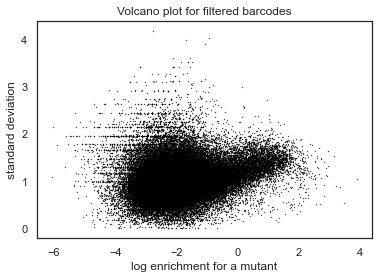

In [10]:
# Compare filtered data to indels and backbone muts

filteredLookupTable = 'NP_11_21_1_BB_AB_lookupTable.csv'
bbMutLookup = 'NP_11_21_1_BB_AB_BBmuts_lookupTable.csv'
indelLookup = 'NP_11_21_1_BB_AB_indels_lookupTable.csv'

filterDF = pd.read_csv(filteredLookupTable, index_col = 0).reset_index().rename(columns = 
                                                {'index': 'filtered', 'Barcode_sequence':'Barcode'})
bbMutDF = pd.read_csv(bbMutLookup, index_col = 0).reset_index().rename(columns = 
                                                {'index': 'backboneMut', 'Barcode_sequence':'Barcode'})
indelDF = pd.read_csv(indelLookup, index_col = 0).reset_index().rename(columns = 
                                                {'index': 'hasIndel', 'Barcode_sequence':'Barcode'})

filterDF = filterDF.merge(BCDFall, how = 'left', on = 'Barcode')
bbMutDF = bbMutDF.merge(BCDFall, how = 'left', on = 'Barcode')
indelDF = indelDF.merge(BCDFall, how = 'left', on = 'Barcode')


plt.scatter(filterDF['BC_avg'], filterDF['BC_stdDev'], s = 0.1, color = 'black')
# plt.scatter(bbMutDF['BC_avg'], bbMutDF['BC_stdDev'], s = 0.1, color = 'red')
# plt.scatter(indelDF['BC_avg'], indelDF['BC_stdDev'], s = 0.1, color = 'orange')
plt.title('Volcano plot for filtered barcodes')
plt.xlabel('log enrichment for a mutant')
plt.ylabel('standard deviation')


Text(0, 0.5, 'standard deviation')

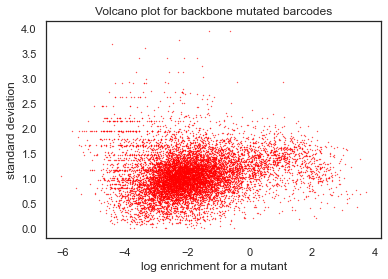

In [11]:
#
plt.scatter(bbMutDF['BC_avg'], bbMutDF['BC_stdDev'], s = 0.1, color = 'red')
plt.title('Volcano plot for backbone mutated barcodes')
plt.xlabel('log enrichment for a mutant')
plt.ylabel('standard deviation')


Text(0, 0.5, 'standard deviation')

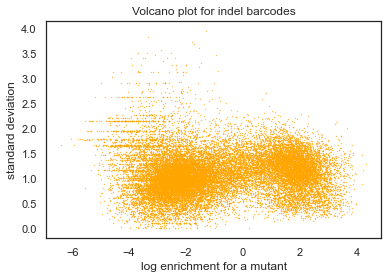

In [12]:
#
plt.scatter(indelDF['BC_avg'], indelDF['BC_stdDev'], s = 0.1, color = 'orange')
plt.title('Volcano plot for indel barcodes')
plt.xlabel('log enrichment for a mutant')
plt.ylabel('standard deviation')


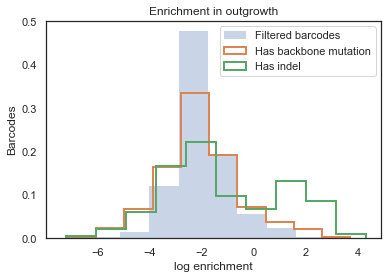

In [13]:
#


plt.hist(filterDF['BC_avg'], density = True, alpha = 0.3, linewidth = 0, label = 'Filtered barcodes')
plt.hist(bbMutDF['BC_avg'], density = True, histtype = 'step', linewidth = 2, label = 'Has backbone mutation')
plt.hist(indelDF['BC_avg'], density = True, histtype = 'step', linewidth = 2, label = 'Has indel')
plt.title('Enrichment in outgrowth')
plt.xlabel('log enrichment')
plt.ylabel('Barcodes')
plt.legend()




In [14]:
# Repeat the cells above for the actual selection
selectionDF['repsAvgLog'] = selectionDF.dropna(subset = ['rep1LogData', 
                                        'rep2LogData'])[['rep1LogData', 'rep2LogData']].mean(axis = 1)
filterDF = filterDF.merge(selectionDF, how = 'left', on = 'Barcode')
bbMutDF = bbMutDF.merge(selectionDF, how = 'left', on = 'Barcode')
indelDF = indelDF.merge(selectionDF, how = 'left', on = 'Barcode')


In [21]:
filterDF[filterDF['correctedAAmut_x'] == 'P449L']

,filtered,Barcode,correctedAAmut_x,PacBio,correctedAAmut_y,NP_11_24_01,NP_11_24_10_1,NP_11_24_11_1,NP_11_24_18,NP_11_24_19,NP_11_27_21,NP_11_27_22,NP_11_27_23_x,NP_11_24_01_enrichment,NP_11_24_10_1_enrichment,NP_11_24_11_1_enrichment,NP_11_24_18_enrichment,NP_11_24_19_enrichment,NP_11_27_21_enrichment,NP_11_27_22_enrichment,NP_11_27_23_enrichment,BC_avg,BC_stdDev,Unnamed: 0,correctedAAmut,NP_11_27_23_y,NP_11_27_24,NP_11_27_25,Raw_PacBio_counts,OriginalAA,MutAA,AAPosition,Mutation,vcMUT/vcWT,Error (fraction of fraction),Sc/o,Sc/o error (+/-),citation,Rep1RawEnrichment,Rep2RawEnrichment,WT_norm_enrich_rep1,WT_norm_enrich_rep2,WT_norm_enrich_avg,mut_BCs_mean,mut_BCs_stdDev,Number_of_BCs_for_mut,Standard_score,Coefficient_of_variation,rep1LogData,rep2LogData,repsAvgLog
2530,159724,AATTTTGACGTCTTT,P449L,4.0,P449L,NaN,6.0,2.0,NaN,NaN,2.0,1.0,13.0,NaN,0.205006,-0.648678,NaN,NaN,-0.387568,-0.976710,-1.542336,-0.670057,0.652093,104330,P449L,13.0,NaN,NaN,4.0,P,L,449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004956,0.001199,11.0,NaN,NaN,NaN,NaN,NaN
5740,165426,GTCGTCTGTCGTGGA,P449L,5.0,P449L,NaN,447.0,376.0,30.0,41.0,13.0,289.0,6046.0,NaN,4.292661,4.364620,1.574862,1.740281,1.261090,4.466573,4.376723,3.153830,1.530546,104328,P449L,6046.0,281.0,287.0,5.0,P,L,449,NaN,NaN,NaN,NaN,NaN,NaN,0.046477,0.047469,0.006275,0.006226,0.006251,0.004956,0.001199,11.0,1.079122,4.132399,-5.071112,-5.079026,-5.075069
16434,183838,CGGCGGGTAGGTGTG,P449L,9.0,P449L,NaN,2.0,8.0,NaN,NaN,8.0,NaN,6.0,NaN,-1.704537,-0.073314,NaN,NaN,0.187796,NaN,-3.126456,-1.179128,1.544824,104325,P449L,6.0,NaN,NaN,9.0,P,L,449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004956,0.001199,11.0,NaN,NaN,NaN,NaN,NaN
28198,203389,CAGCCATTAAAGGTT,P449L,14.0,P449L,NaN,121.0,63.0,40.0,26.0,23.0,115.0,3036.0,NaN,1.956274,1.548546,0.832925,0.255186,0.802016,2.515459,2.658248,1.509808,0.918722,104323,P449L,3036.0,81.0,104.0,14.0,P,L,449,NaN,NaN,NaN,NaN,NaN,NaN,0.026680,0.034256,0.003602,0.004493,0.004048,0.004956,0.001199,11.0,-0.757691,4.132399,-5.626162,-5.405262,-5.515712
42093,225189,TATTTTTCCACTAGT,P449L,19.0,P449L,NaN,4.0,2.0,1.0,1.0,NaN,NaN,5.0,NaN,-1.758604,-2.206823,-3.161336,-3.308292,NaN,NaN,-4.055992,-2.898209,0.915776,104329,P449L,5.0,NaN,NaN,19.0,P,L,449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004956,0.001199,11.0,NaN,NaN,NaN,NaN,NaN
45928,231088,ACGAATGGTCGGCGT,P449L,22.0,P449L,NaN,13.0,15.0,NaN,1.0,1.0,2.0,16.0,NaN,-0.726552,-0.338523,NaN,-3.454895,-2.785464,-1.988311,-3.039445,-2.055532,1.278900,104326,P449L,16.0,NaN,1.0,22.0,P,L,449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004956,0.001199,11.0,NaN,NaN,NaN,NaN,NaN
57155,248199,TAACTGTTATGCTTC,P449L,30.0,P449L,2.0,33.0,19.0,5.0,1.0,33.0,2.0,93.0,2.153206,-0.105149,-0.412290,-2.008657,-3.765050,0.400889,-2.298466,-1.589589,-1.396902,1.455018,104322,P449L,93.0,NaN,NaN,30.0,P,L,449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004956,0.001199,11.0,NaN,NaN,NaN,NaN,NaN
72731,271563,TCCGAGTCGGACCCT,P449L,44.0,P449L,NaN,95.0,66.0,10.0,3.0,307.0,46.0,1006.0,NaN,0.569228,0.449934,-1.698502,-3.049430,2.248237,0.454036,0.408557,-0.088277,1.736063,104321,P449L,1006.0,26.0,32.0,44.0,P,L,449,NaN,NaN,NaN,NaN,NaN,NaN,0.025845,0.031809,0.003490,0.004172,0.003831,0.004956,0.001199,11.0,-0.938449,4.132399,-5.657956,-5.479358,-5.568657
75811,276220,TTGCGGTTCAGGATC,P449L,50.0,P449L,NaN,4.0,26.0,2.0,5.0,9.0,NaN,62.0,NaN,-2.726188,-0.609458,-3.435773,-2.666438,-1.409220,NaN,-2.505880,-2.225493,1.026294,104324,P449L,62.0,5.0,NaN,50.0,P,L,449,NaN,NaN,NaN,NaN,NaN,NaN,0.080645,NaN,0.010889,NaN,NaN,0.004956,0.001199,11.0,NaN,NaN,-4.520011,NaN,NaN


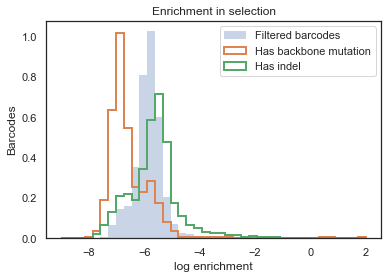

In [16]:
# Plot selection histogram


bins = np.linspace(-9, 2, 40)


plt.hist(filterDF['repsAvgLog'], bins = bins, density = True, alpha = 0.3, linewidth = 0, label = 'Filtered barcodes')
plt.hist(bbMutDF['repsAvgLog'], bins = bins, density = True, histtype = 'step', linewidth = 2, label = 'Has backbone mutation')
plt.hist(indelDF['repsAvgLog'], bins = bins, density = True, histtype = 'step', linewidth = 2, label = 'Has indel')
plt.title('Enrichment in selection')
plt.xlabel('log enrichment')
plt.ylabel('Barcodes')
plt.legend()

